In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
%matplotlib qt

In [3]:
import math

# Helper method to plot multiple images
def plot_multiple_images(images,names,gray=False,number_of_cols=6,w_factor=4,h_factor=2):
    
    number_of_images=len(images)

    number_of_rows=math.ceil(number_of_images*1.0/number_of_cols)

    
    
    fig_width=w_factor*number_of_cols  
    fig_height=h_factor*number_of_rows
    
    if number_of_rows > 5 :
        _dpi = number_of_rows * 5
    else :
        _dpi = 30
    
    #fig=plt.figure(figsize=(fig_width, fig_height),dpi=_dpi, facecolor='w', edgecolor='w')
    fig=plt.figure(figsize=(fig_width, fig_height), facecolor='w', edgecolor='w')
    
    im_number=0
    for im, name in zip(images,names):
        im_number+=1
        plt.subplot(number_of_rows,number_of_cols,im_number)
        plt.title(name)
        if gray :
            plt.imshow(im,cmap='gray')
        else :
            plt.imshow(im)

# Camera calibration

In [4]:
# Get object points
col_points=9
row_points=6

objp = np.zeros((row_points*col_points,3), np.float32)
objp[:,:2] = np.mgrid[0:col_points, 0:row_points].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [5]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

sample_images=[]
sample_im_names=[]

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (col_points,row_points), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (col_points,row_points), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        if len(sample_images) < 4 :
            sample_images.append(img)
            sample_im_names.append(fname)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [6]:
%matplotlib inline

# sample chessboard images

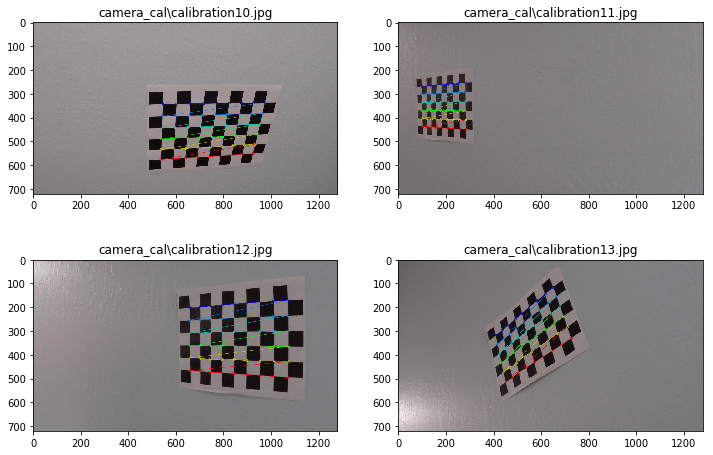

In [7]:
plot_multiple_images(sample_images,sample_im_names,number_of_cols=2,w_factor=6,h_factor=4)

# Undistort image

In [8]:
# Test undistortion on an image
img = cv2.imread('camera_cal/test_calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

ims=[img,dst]
names=['distorted','undistorted']

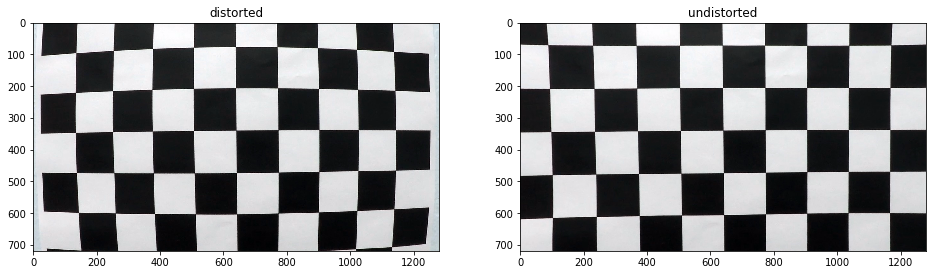

In [9]:
plot_multiple_images(ims,names,number_of_cols=2,w_factor=8,h_factor=6)

# Read and undistort sample road image

In [10]:
img = cv2.imread('test_images/test4.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

ims=[img,undistorted]
names=['distorted','undistorted']

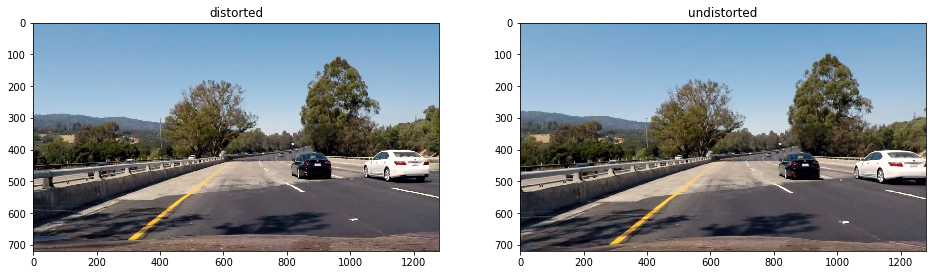

In [11]:
plot_multiple_images(ims,names,number_of_cols=2,w_factor=8,h_factor=6)

# Edge detection using sobel x , s_channel and l_channel filtering

In [13]:

def edge_detection_pipeline(img, s_thresh=(170, 255),l_thresh=(100, 255), sx_thresh=(20, 100),get_colored_binary=False):
    #img = np.copy(img)
    
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
        
    l_channel = hls[:,:,1]
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    ls_binary = np.zeros_like(s_binary)
    ls_binary[(s_binary == 1) & (l_binary == 1)] = 1
    
    color_binary=None
    if get_colored_binary :
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, ls_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(ls_binary == 1) | (sxbinary == 1)] = 1
    return color_binary,combined_binary

# Edges for sample image

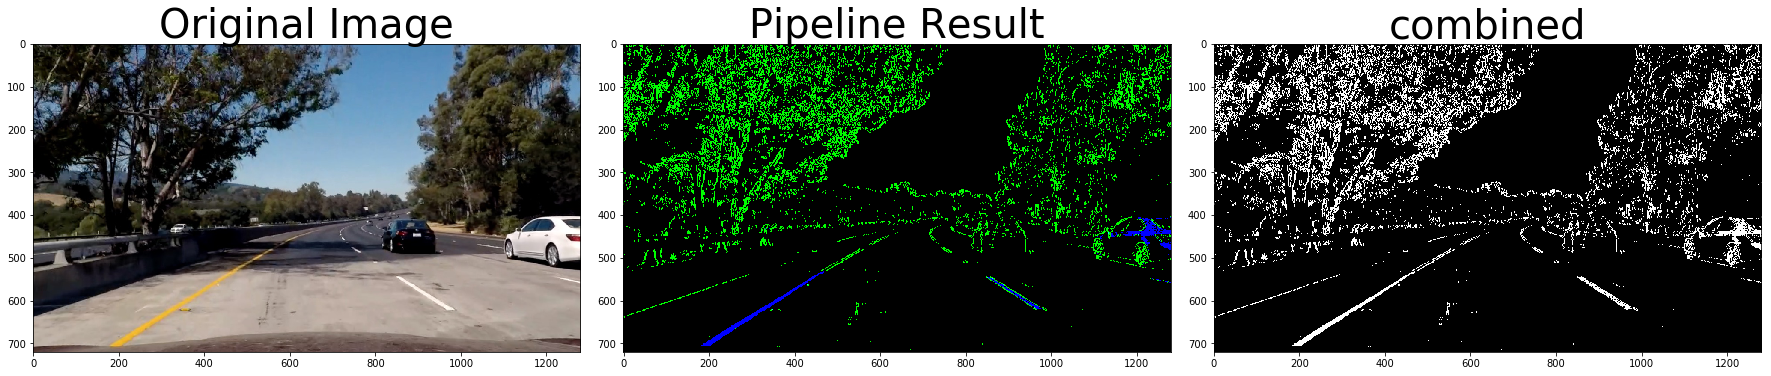

In [14]:
img = cv2.imread('test_images/test5.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

colored, edges = edge_detection_pipeline(undistorted,get_colored_binary=True)

# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(colored)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(edges,cmap='gray')
ax3.set_title('combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Get prespective transformation metrix using sraight lane line image

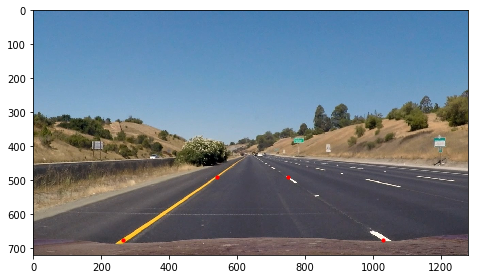

In [15]:
img_straight = cv2.imread('test_images/straight_lines1.jpg')
img_straight=cv2.cvtColor(img_straight,cv2.COLOR_BGR2RGB)

# Define source and destination points

plt.figure(figsize=(8, 4.5), facecolor='w', edgecolor='w')
plt.imshow(img_straight)
plt.scatter([265], [675],c='r', s=10)
plt.scatter([1030], [675],c='r', s=10)
plt.scatter([540], [490],c='r', s=10)
plt.scatter([749], [490],c='r', s=10)

src=np.float32([[265 ,675],[1030,675], [540,490], [749 ,490]])
dst = np.float32([[265 ,675],[1030,675], [265,150], [1030 ,150]])


In [16]:
M = cv2.getPerspectiveTransform(src, dst)

In [17]:
straight_undistorted = cv2.undistort(img_straight, mtx, dist, None, mtx)
img_size = (straight_undistorted.shape[1],straight_undistorted.shape[0])
warped = cv2.warpPerspective(straight_undistorted, M, img_size, flags=cv2.INTER_LINEAR)

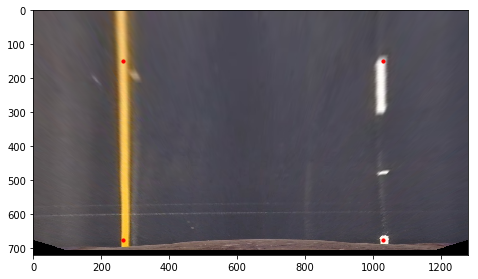

In [18]:
plt.figure(figsize=(8, 4.5), facecolor='w', edgecolor='w')
plt.imshow(warped)
plt.scatter([265], [675],c='r', s=10)
plt.scatter([1030], [675],c='r', s=10)
plt.scatter([265], [150],c='r', s=10)
plt.scatter([1030], [150],c='r', s=10)

# Prespective transform for curve lanes

In [19]:
img = cv2.imread('vid_images/frame100.jpg')
colored, edges = edge_detection_pipeline(img)
#img=cv2.cvtColor(edges,cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(edges, mtx, dist, None, mtx)
img_size = (edges.shape[1],undistorted.shape[0])
binary_warped = cv2.warpPerspective(edges, M, img_size, flags=cv2.INTER_LINEAR)

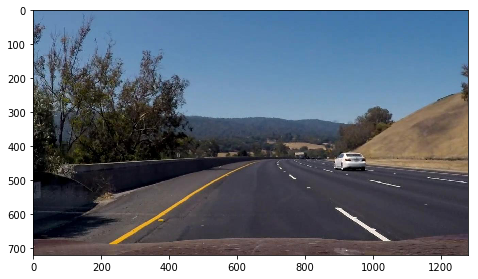

In [22]:
plt.figure(figsize=(8, 4.5), facecolor='w', edgecolor='w')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

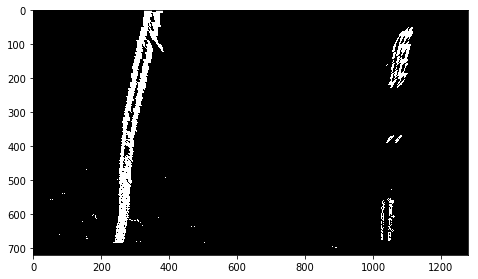

In [23]:
plt.figure(figsize=(8, 4.5), facecolor='w', edgecolor='w')
plt.imshow(binary_warped,cmap='gray')

In [24]:
# Take a histogram of the bottom half of the image
#binary_warped.shape[0]/2
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

In [25]:
out_img_copy=out_img.copy()

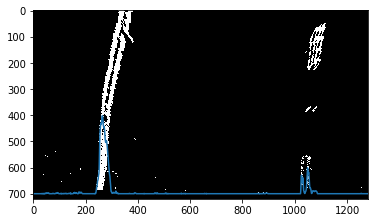

In [26]:
histogram_to_plot= np.zeros_like(histogram)
histogram_to_plot=700
histogram_to_plot = histogram_to_plot - histogram # invert the position
plt.plot(histogram_to_plot)
plt.imshow(out_img)

In [27]:
midpoint = np.int(histogram.shape[0]/2)
left_lane_starting_point = np.argmax(histogram[:midpoint]) # argmax give position of max value
right_lane_starting_point = np.argmax(histogram[midpoint:]) + midpoint
print(left_lane_starting_point)
print(right_lane_starting_point)

264
1049


In [28]:
# the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

In [29]:
nonzero = binary_warped.nonzero()
y_coordinates = np.array(nonzero[0]) # y corninate for non zero pixel
x_coordinates = np.array(nonzero[1]) # X corninate for non zero pixel

In [30]:
# Current positions to be updated for each window
left_win_center = left_lane_starting_point
right_win_center = right_lane_starting_point

In [31]:
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

In [32]:
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [33]:
binary_warped.shape[0]

720

In [34]:
for window in range(nwindows):
    win_top = binary_warped.shape[0] - (window+1)*window_height
    win_bottom = binary_warped.shape[0] - window*window_height
    win_1_left = left_win_center - margin
    win_1_right = left_win_center + margin
    win_2_left = right_win_center - margin
    win_2_right = right_win_center + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_1_left,win_top),(win_1_right,win_bottom),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_2_left,win_top),(win_2_right,win_bottom),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    indices_in_left_window = ((y_coordinates >= win_top) & (y_coordinates < win_bottom) &  (x_coordinates >= win_1_left) &  (x_coordinates < win_1_right)).nonzero()[0]
    indices_in_right_window = ((y_coordinates >= win_top) & (y_coordinates < win_bottom) &  (x_coordinates >= win_2_left) &  (x_coordinates < win_2_right)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(indices_in_left_window)
    right_lane_inds.append(indices_in_right_window)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(indices_in_left_window) > minpix:
        left_win_center = np.int(np.mean(x_coordinates[indices_in_left_window]))
    if len(indices_in_right_window) > minpix:        
        right_win_center = np.int(np.mean(x_coordinates[indices_in_right_window]))

In [35]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
left_lane_x_coordinates = x_coordinates[left_lane_inds]
left_lane_y_coordinates = y_coordinates[left_lane_inds] 
right_lane_x_coordinates = x_coordinates[right_lane_inds]
right_lane_y_coordinates = y_coordinates[right_lane_inds] 

# Fit a second order polynomial to each
left_lane_coef  = np.polyfit(left_lane_y_coordinates, left_lane_x_coordinates, 2)
right_lane_coef = np.polyfit(right_lane_y_coordinates, right_lane_x_coordinates, 2)

In [36]:
# Generate x and y values for plotting
final_y_coordinates = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
final_left_lane_coordinates = left_lane_coef[0]*final_y_coordinates**2 + left_lane_coef[1]*final_y_coordinates + left_lane_coef[2]
final_right_lane_coordinates = right_lane_coef[0]*final_y_coordinates**2 + right_lane_coef[1]*final_y_coordinates + right_lane_coef[2]

(720, 0)

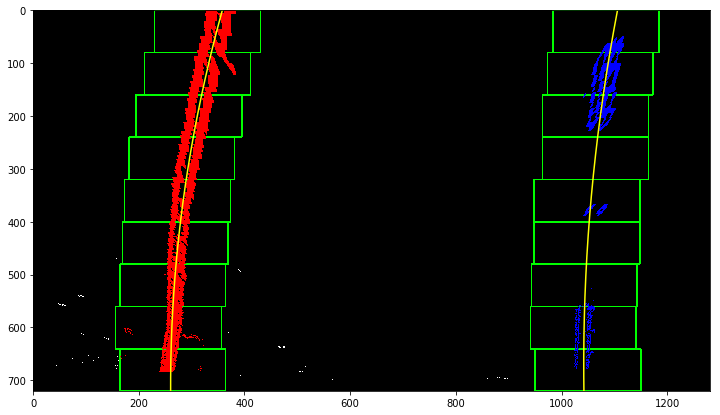

In [37]:
out_img[y_coordinates[left_lane_inds], x_coordinates[left_lane_inds]] = [255, 0, 0]
out_img[y_coordinates[right_lane_inds], x_coordinates[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(15, 7), facecolor='w', edgecolor='w')

plt.imshow(out_img)
plt.plot(final_left_lane_coordinates, final_y_coordinates, color='yellow')
plt.plot(final_right_lane_coordinates, final_y_coordinates, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

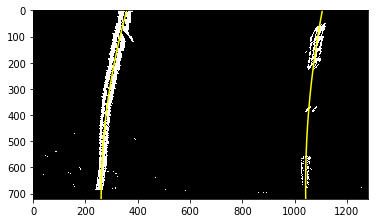

In [38]:
plt.imshow(out_img_copy)
plt.plot(final_left_lane_coordinates, final_y_coordinates, color='yellow')
plt.plot(final_right_lane_coordinates, final_y_coordinates, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [39]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 # dstak stack array depth wise
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[y_coordinates[left_lane_inds], x_coordinates[left_lane_inds]] = [255, 0, 0]
out_img[y_coordinates[right_lane_inds], x_coordinates[right_lane_inds]] = [0, 0, 255]

In [40]:
lane_image = np.zeros_like(out_img)

margin=20

left_line_1 = np.array([np.transpose(np.vstack([final_left_lane_coordinates-margin, final_y_coordinates]))]) #vstack stack array virtically (on above other)
left_line_2 = np.array([np.flipud(np.transpose(np.vstack([final_left_lane_coordinates+margin,final_y_coordinates])))]) # flipud : flip upside down

left_line_pts = np.hstack((left_line_1, left_line_2)) # hstack stack horizontally

right_line_1 = np.array([np.transpose(np.vstack([final_right_lane_coordinates-margin, final_y_coordinates]))])
right_line_2 = np.array([np.flipud(np.transpose(np.vstack([final_right_lane_coordinates+margin,final_y_coordinates])))])
right_line_pts = np.hstack((right_line_1, right_line_2))


left_line = np.array([np.flipud(np.transpose(np.vstack([final_left_lane_coordinates,final_y_coordinates])))])
right_line = np.array([np.transpose(np.vstack([final_right_lane_coordinates, final_y_coordinates]))])
lane_line_pts = np.hstack((left_line, right_line))

cv2.fillPoly(lane_image, np.int_([left_line_pts]), (255,255,0))
cv2.fillPoly(lane_image, np.int_([right_line_pts]), (255,255,0))
cv2.fillPoly(lane_image, np.int_([lane_line_pts]), (0,255,0))


Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (lane_image.shape[1],lane_image.shape[0])
unwarped = cv2.warpPerspective(lane_image, Minv, img_size, flags=cv2.INTER_LINEAR)

ims=[lane_image,unwarped]
names=['lanes found','unwarped to original prespective']


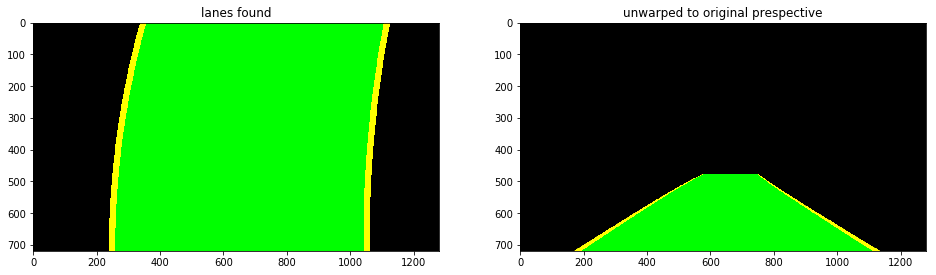

In [41]:
plot_multiple_images(ims,names,number_of_cols=2,w_factor=8,h_factor=6)

# Overlay found lanes on original undistorted image

In [42]:
img = cv2.imread('vid_images/frame100.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
img_with_lanes = cv2.addWeighted(undistorted, 1, unwarped, 0.3, 0)
ims=[undistorted,img_with_lanes]
names=['undistorted image','image with lane and lines marked']

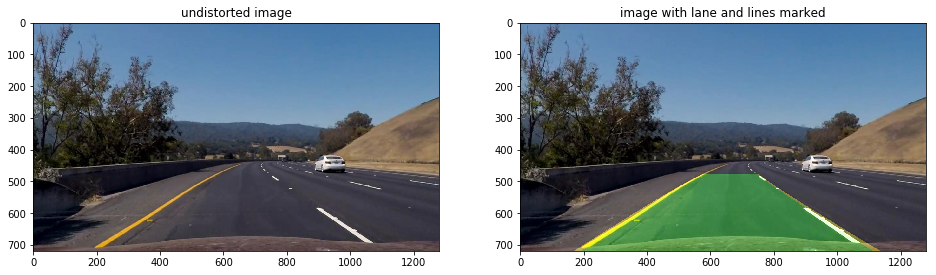

In [43]:
plot_multiple_images(ims,names,number_of_cols=2,w_factor=8,h_factor=6)

# Curvature calculation

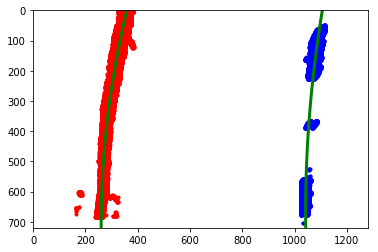

In [44]:
# plot points of lane and lane marking
mark_size = 3
plt.plot(left_lane_x_coordinates, left_lane_y_coordinates, 'o', color='red', markersize=mark_size)
plt.plot(right_lane_x_coordinates, right_lane_y_coordinates, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(final_left_lane_coordinates, final_y_coordinates, color='green', linewidth=3)
plt.plot(final_right_lane_coordinates, final_y_coordinates, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [45]:
y_eval = np.max(final_y_coordinates)
left_curverad = ((1 + (2*left_lane_coef [0]*y_eval + left_lane_coef [1])**2)**1.5) / np.absolute(2*left_lane_coef [0])
right_curverad = ((1 + (2*right_lane_coef[0]*y_eval + right_lane_coef[1])**2)**1.5) / np.absolute(2*right_lane_coef[0])
print(left_curverad, right_curverad)

2578.7340889075967 3510.9983604152508


In [46]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_lane_coef_cr = np.polyfit(left_lane_y_coordinates*ym_per_pix, left_lane_x_coordinates*xm_per_pix, 2)
right_lane_coef_cr = np.polyfit(right_lane_y_coordinates*ym_per_pix, right_lane_x_coordinates*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_lane_coef_cr[0]*y_eval*ym_per_pix + left_lane_coef_cr[1])**2)**1.5) / np.absolute(2*left_lane_coef_cr[0])
right_curverad = ((1 + (2*right_lane_coef_cr[0]*y_eval*ym_per_pix + right_lane_coef_cr[1])**2)**1.5) / np.absolute(2*right_lane_coef_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

846.9793568610747 m 1152.8651666941628 m


# Pipeline for video

In [47]:
# the source and destination as based on test image with straight lines
def get_prespective_tranfrom_matries():
    #src=np.float32([[265 ,675],[1030,675], [604,445], [675 ,445]])
    #dst = np.float32([[265 ,675],[1030,675], [265,50], [1030 ,50]])
    src=np.float32([[265 ,675],[1030,675], [540,490], [749 ,490]])
    dst = np.float32([[265 ,675],[1030,675], [265,150], [1030 ,150]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

In [48]:
# find the edges, undistort and do prespective warp 
def undistort_find_edges_and_prespective_transform(img,mtx,dist,M):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    colored, edges = edge_detection_pipeline(undistorted,get_colored_binary=True)    
    img_size = (edges.shape[1],undistorted.shape[0])
    binary_warped = cv2.warpPerspective(edges, M, img_size, flags=cv2.INTER_LINEAR)   
    return undistorted, binary_warped, colored

In [49]:
# Get indices of pixels on lane
def get_fit_indices_for_first_frame(binary_warped,number_of_windows,window_height,x_coordinates,y_coordinates,margin = 100):
    
    
    #histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    histogram = np.sum(binary_warped, axis=0)
    
    box_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    left_lane_starting_point = np.argmax(histogram[:midpoint])
    right_lane_starting_point = np.argmax(histogram[midpoint:]) + midpoint
    
    # set current window mid to base postions
    left_win_center = left_lane_starting_point
    right_win_center = right_lane_starting_point
    

    # Set minimum number of pixels found to recenter window
    minpix = 100 # was 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    left_lane_pos=None
    right_lane_pos=None
    
    for window in range(number_of_windows):
        win_top = binary_warped.shape[0] - (window+1)*window_height
        win_bottom = binary_warped.shape[0] - window*window_height
        win_1_left = left_win_center - margin
        win_1_right = left_win_center + margin
        win_2_left = right_win_center - margin
        win_2_right = right_win_center + margin
        # Draw the windows on the visualization image
        cv2.rectangle(box_image,(win_1_left,win_top),(win_1_right,win_bottom),(0,255,0), 2) 
        cv2.rectangle(box_image,(win_2_left,win_top),(win_2_right,win_bottom),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((y_coordinates >= win_top) & (y_coordinates < win_bottom) &  (x_coordinates >= win_1_left) &  (x_coordinates < win_1_right)).nonzero()[0]
        good_right_inds = ((y_coordinates >= win_top) & (y_coordinates < win_bottom) &  (x_coordinates >= win_2_left) &  (x_coordinates < win_2_right)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_win_center = np.int(np.mean(x_coordinates[good_left_inds]))     
        if len(good_right_inds) > minpix:        
            right_win_center = np.int(np.mean(x_coordinates[good_right_inds]))            
            
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    y=np.linspace(0, len(histogram)-1,len(histogram))
    new_hist=700-histogram
    hist_pts=np.dstack([y,new_hist])
    hist_pts=hist_pts.astype(np.int32)
    
    cv2.polylines(box_image,[hist_pts],False,(255,0,0),thickness=5)
    
    return left_lane_inds, right_lane_inds, box_image
    

In [50]:
# find points around previous frame polynomial
# This method is not in use
def get_fit_indices_for_other_frames(binary_warped,left_lane_coef ,right_lane_coef):
    box_image = np.dstack((binary_warped,binary_warped,binary_warped)) * 255
    
    nonzero = binary_warped.nonzero()
    y_coordinates = np.array(nonzero[0])
    x_coordinates = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((x_coordinates > (left_lane_coef [0]*(y_coordinates**2) + left_lane_coef [1]*y_coordinates + 
    left_lane_coef [2] - margin)) & (x_coordinates < (left_lane_coef [0]*(y_coordinates**2) + 
    left_lane_coef [1]*y_coordinates + left_lane_coef [2] + margin))) 

    right_lane_inds = ((x_coordinates > (right_lane_coef[0]*(y_coordinates**2) + right_lane_coef[1]*y_coordinates + 
    right_lane_coef[2] - margin)) & (x_coordinates < (right_lane_coef[0]*(y_coordinates**2) + 
    right_lane_coef[1]*y_coordinates + right_lane_coef[2] + margin)))
    

    return left_lane_inds, right_lane_inds, box_image

In [51]:
# Get radius of curvature of lane
def get_radius_of_curvature(left_lane_y_coordinates,left_lane_x_coordinates,right_lane_y_coordinates,right_lane_x_coordinates,final_y_coordinates):
    y_eval = np.max(final_y_coordinates)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_lane_coef_cr = np.polyfit(left_lane_y_coordinates*ym_per_pix, left_lane_x_coordinates*xm_per_pix, 2)
    right_lane_coef_cr = np.polyfit(right_lane_y_coordinates*ym_per_pix, right_lane_x_coordinates*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_lane_coef_cr[0]*y_eval*ym_per_pix + left_lane_coef_cr[1])**2)**1.5) / np.absolute(2*left_lane_coef_cr[0])
    right_curverad = ((1 + (2*right_lane_coef_cr[0]*y_eval*ym_per_pix + right_lane_coef_cr[1])**2)**1.5) / np.absolute(2*right_lane_coef_cr[0])
    
    radius = (left_curverad + left_curverad) /2
    
    return radius

In [52]:
# class to detect lane pixels and their coordinates
class LaneFinder(object):
    
    def __init__(self):
        self.first_frame=True        
        self.left_lane_coef = None
        self.right_lane_coef= None
    
    # Find lane pixels and their coordinates and finally calculate coeffients of polynomial
    def find_lane_coordinates_and_poly_coefficients(self,binary_warped):
        #print('first frame? : ', self.first_frame)        
        
        nonzero = binary_warped.nonzero()
        y_coordinates = np.array(nonzero[0])
        x_coordinates = np.array(nonzero[1])

        if self.first_frame :
            # the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # for first image get pixel indices corresponds to left and right lanes
            left_lane_inds,right_lane_inds,box_image = get_fit_indices_for_first_frame(binary_warped,nwindows,
                                                        window_height,x_coordinates,y_coordinates,margin = 100)
            #self.first_frame = False 
        else :
            left_lane_inds,right_lane_inds,box_image = get_fit_indices_for_other_frames(binary_warped,
                                                        self.left_lane_coef ,self.right_lane_coef)

        # extract left and right line pixel positions
        self.left_lane_x_coordinates = x_coordinates[left_lane_inds]
        self.left_lane_y_coordinates = y_coordinates[left_lane_inds] 
        self.right_lane_x_coordinates = x_coordinates[right_lane_inds]
        self.right_lane_y_coordinates = y_coordinates[right_lane_inds]
        
        self.final_y_coordinates = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        # Fit a second order polynomial to each
        self.left_lane_coef  = np.polyfit(self.left_lane_y_coordinates, self.left_lane_x_coordinates, 2)
        self.right_lane_coef = np.polyfit(self.right_lane_y_coordinates, self.right_lane_x_coordinates, 2)                     
        
        return box_image
    
    # Get x and y coordinates of lanes based on polynomial equation
    def get_lane_coordinates(self,binary_warped):
        final_left_lane_coordinates = self.left_lane_coef[0]*self.final_y_coordinates**2 + \
                                        self.left_lane_coef[1]*self.final_y_coordinates + self.left_lane_coef[2]
        final_right_lane_coordinates = self.right_lane_coef[0]*self.final_y_coordinates**2 + \
                                        self.right_lane_coef[1]*self.final_y_coordinates + self.right_lane_coef[2]
        
        return final_left_lane_coordinates, final_right_lane_coordinates, self.final_y_coordinates
    
    # Get distance of car from center of lane and radius of curvature of lane
    def get_dist_from_center_of_lane_and_curvature(self):
        
        left_lane_position = self.left_lane_coef[0]*np.max(self.final_y_coordinates)**2 + \
                                self.left_lane_coef[1]*np.max(self.final_y_coordinates) + self.left_lane_coef[2]
        right_lane_position = self.right_lane_coef[0]*np.max(self.final_y_coordinates)**2 + \
                                self.right_lane_coef[1]*np.max(self.final_y_coordinates) + self.right_lane_coef[2]
               
        xm_per_pix = 3.7/700
        car_center = binary_warped.shape[1]//2        
        away_from_left = (left_lane_position + right_lane_position) // 2        
        away_from_center = car_center - away_from_left
        away_from_center_m = away_from_center * xm_per_pix
        
        radius = get_radius_of_curvature(self.left_lane_y_coordinates,self.left_lane_x_coordinates,self.right_lane_y_coordinates,self.right_lane_x_coordinates,self.final_y_coordinates)
        
        return away_from_center_m, radius
    
    # Get image with points on lanes
    def get_points_on_lane_image(self,binary_warped):
        
        points_img=np.dstack((binary_warped,binary_warped,binary_warped)) * 255
        points_img[self.left_lane_y_coordinates, self.left_lane_x_coordinates] = [255, 0, 0]
        points_img[self.right_lane_y_coordinates, self.right_lane_x_coordinates] = [0, 0, 255]  
        
        return points_img
        

In [53]:
# based on pixel on polynomial create fill image with lane line marking and lane higlighting
def get_lane_marking(binary_warped,final_left_lane_coordinates,final_right_lane_coordinates,final_y_coordinates): 
 

    lane_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
    line_image = np.zeros_like(lane_image)
    
    margin=20
    
    # For yellow lane marking of left lane line
    # combine x and y cordinates of left part of left lane  [[x1,y1],[x2,y2] .. ]
    left_line_1 = np.array([np.transpose(np.vstack([final_left_lane_coordinates-margin, final_y_coordinates]))]) #vstack stack array virtically (on above other)
    # combine x and y cordinates of right part of left lane  [[x1,y1],[x2,y2] ..] and then change order to fill polygon [flipud] [[xn,yn],[xn-1,yn-1] ..] : 
    left_line_2 = np.array([np.flipud(np.transpose(np.vstack([final_left_lane_coordinates+margin,final_y_coordinates])))]) # flipud : flip upside down
    # concatenate all points of left lane
    left_line_pts = np.hstack((left_line_1, left_line_2)) # hstack stack horizontally
    
    # For yellow lane marking of left lane line
    # combine x and y cordinates of left part of right lane  [[x1,y1],[x2,y2] .. ]
    right_line_1 = np.array([np.transpose(np.vstack([final_right_lane_coordinates-margin, final_y_coordinates]))])
    # combine x and y cordinates of right part of right lane  [[x1,y1],[x2,y2] ..] and then change order to fill polygon [flipud] [[xn,yn],[xn-1,yn-1] ..] : 
    right_line_2 = np.array([np.flipud(np.transpose(np.vstack([final_right_lane_coordinates+margin,final_y_coordinates])))])
    # concatenate all points of right lane
    right_line_pts = np.hstack((right_line_1, right_line_2))

    # For green marking on road portion
    # combine x and y cordinates of left of lane [[x1,y1],[x2,y2] ..] and then change order to fill polygon [flipud] [[xn,yn],[xn-1,yn-1] ..] : 
    left_line = np.array([np.flipud(np.transpose(np.vstack([final_left_lane_coordinates,final_y_coordinates])))])
    # combine x and y cordinates of left part lane  [[x1,y1],[x2,y2] .. ]
    right_line = np.array([np.transpose(np.vstack([final_right_lane_coordinates, final_y_coordinates]))])
    # concatenate all points of right lane
    lane_line_pts = np.hstack((left_line, right_line))

    # yellow colored lane lines
    cv2.fillPoly(lane_image, np.int_([left_line_pts]), (255,255,0))
    cv2.fillPoly(lane_image, np.int_([right_line_pts]), (255,255,0))
    
    # green colored road portion
    cv2.fillPoly(lane_image, np.int_([lane_line_pts]), (0,255,0))
    
    # only lane lines on line image (green) for image 3
    cv2.fillPoly(line_image, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(line_image, np.int_([right_line_pts]), (0,255,0))
    
    return lane_image, line_image


In [54]:
def unwarp_lane_image(lane_image,Minv):
    img_size = (lane_image.shape[1],lane_image.shape[0])
    unwarped = cv2.warpPerspective(lane_image, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

In [55]:
lane_finder=LaneFinder()
M,Minv=get_prespective_tranfrom_matries()

img = cv2.imread('camera_cal/test_calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [56]:
def vedio_pipeline(image):
    
    # first undistort image using camera calibration and find edges using sobel and s channel filter and l channel filter
    # Then do prespective transform of binary image    
    # image 1 : get colour binary
    undistorted, binary_warpped, colored_binary = undistort_find_edges_and_prespective_transform(image,mtx,dist,M) 
    
    # image : 2
    box_image = lane_finder.find_lane_coordinates_and_poly_coefficients(binary_warpped)
    final_left_lane_coordinates, final_right_lane_coordinates,final_y_coordinates = lane_finder.get_lane_coordinates(binary_warpped)
    
    # image 3
    lane_image,line_image = get_lane_marking(binary_warpped,final_left_lane_coordinates, final_right_lane_coordinates, final_y_coordinates)
            
    # generate image with points on lane and lane marking
    points_img = lane_finder.get_points_on_lane_image(binary_warpped)    
    points_and_polyline_img = cv2.addWeighted(points_img, 1, line_image, 0.3, 0)
    
       
    # get dist from lane centre and radius of curvature of lane 
    away_from_center,radii, = lane_finder.get_dist_from_center_of_lane_and_curvature()
    away_center = 'Away from center    : '+str(round(away_from_center,2)) + ' m'
    radius =      'Radius of curvature : '+str(round(radii,2)) + ' m' 
    
    # image 4 : Write text on  
    stat_image=np.zeros_like(points_and_polyline_img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(stat_image,away_center,(10,450), font, 2,(255,255,255),4,cv2.LINE_AA)
    cv2.putText(stat_image,radius,(10,600), font, 2,(255,255,255),4,cv2.LINE_AA)
    
    
    # Create top image with intermediate steps and stats 
    top_img = np.concatenate((colored_binary,box_image,points_and_polyline_img,stat_image), axis=1)
    top_img=cv2.resize(top_img,(1280,180)) # 240
    
    # image 5 : impose lane lines on original image
    unwarped = unwarp_lane_image(lane_image,Minv)
    img_with_lanes = cv2.addWeighted(undistorted, 1, unwarped, 0.8, 0)
    img_with_lanes=cv2.resize(img_with_lanes,(1280,540),fx=1.0,fy=0.666) #480
    
    # Create final image to render
    stacked_image = np.concatenate((top_img, img_with_lanes), axis=0)
    
    return stacked_image
    
    

# Test pipeline on video images

In [57]:
'''
input_video='./project_video.mp4'
clip = VideoFileClip(input_video)#.subclip(0,5) 
list_of_files=clip.write_images_sequence('vid_images/frame%03d.jpg',fps=4)
del clip
'''


"\ninput_video='./project_video.mp4'\nclip = VideoFileClip(input_video)#.subclip(0,5) \nlist_of_files=clip.write_images_sequence('vid_images/frame%03d.jpg',fps=4)\ndel clip\n"

In [58]:
video_images = glob.glob('vid_images/frame*.jpg')

In [59]:
def get_image(fname):
    img = cv2.imread(fname)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb

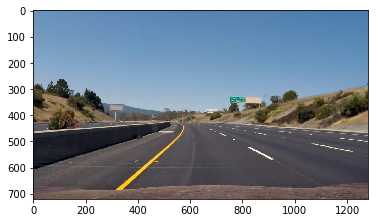

In [60]:
im1= get_image(video_images[0])
plt.imshow(im1)


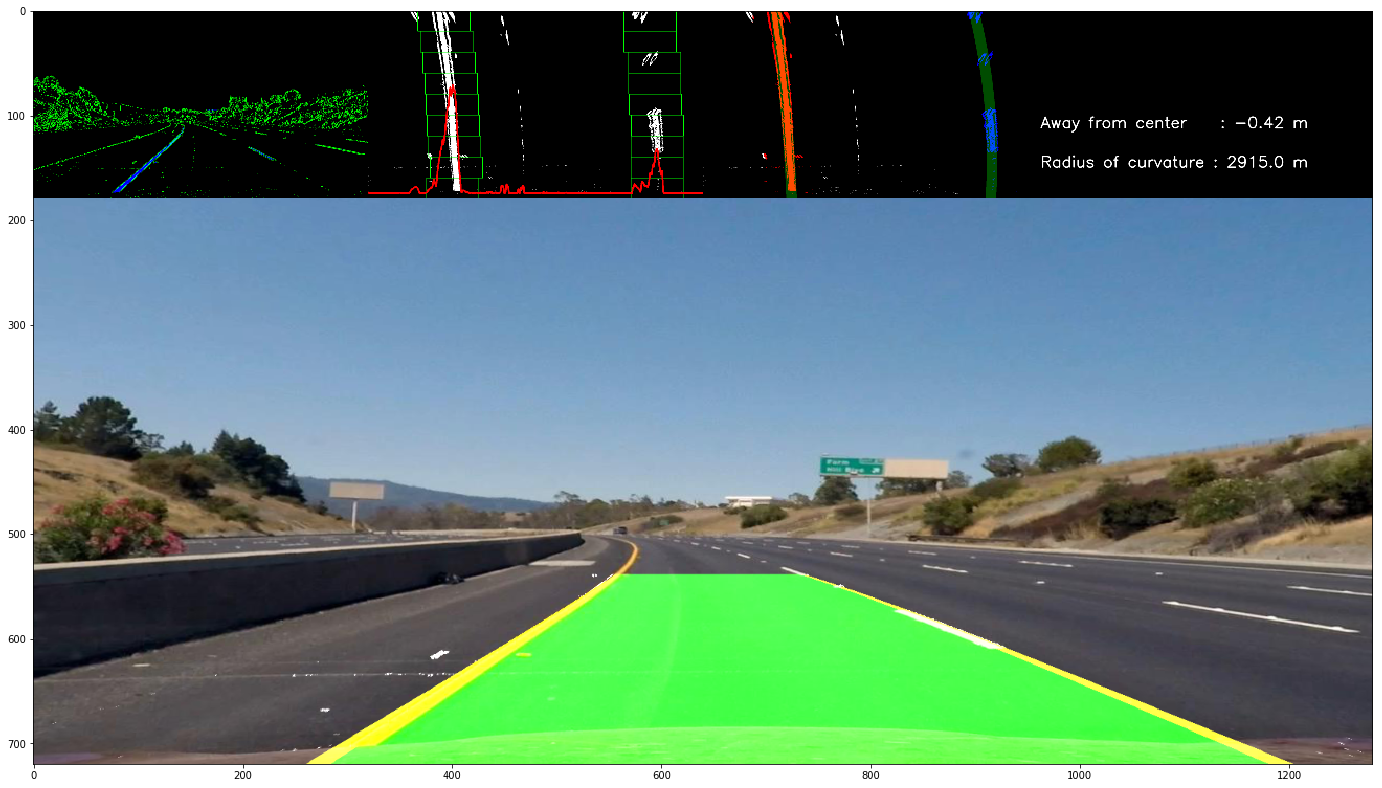

In [61]:
processed1=vedio_pipeline(im1)
plt.figure(figsize=(24, 14), facecolor='w', edgecolor='w')
plt.imshow(processed1)

# Processing on video

In [62]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [63]:
input_video='./project_video.mp4'
output_video = './project_video_output.mp4'

clip1 = VideoFileClip(input_video)#.subclip(19,25)
out_clip = clip1.fl_image(vedio_pipeline)
%time out_clip.write_videofile(output_video, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

out_clip.reader.close()
out_clip.audio.reader.close_proc()

del clip1
del out_clip

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [04:30<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 4min 33s


In [64]:
# 1280 x 720
HTML("""
<video width="1280" height="720" controls> 
  <source src="{0}">
</video>
""".format(output_video))

In [74]:

input_video='./project_video_output.mp4'
clip = VideoFileClip(input_video).subclip(0,5) 
list_of_files=clip.write_images_sequence('for_animation/frame%03d.jpg',fps=8)
del clip


[MoviePy] Writing frames for_animation/frame%03d.jpg.

40it [00:02, 15.89it/s]              


[MoviePy]: Done writing frames for_animation/frame%03d.jpg.



In [66]:
import imageio
import os

In [71]:
dir_path='./for_animation'
filenames=[x for x in os.listdir(dir_path)]

In [76]:
images = []
for filename in filenames:
    filepath=dir_path+"/"+filename
    im = imageio.imread(filepath)
    im = cv2.resize(im,(640,360))
    images.append(im)
imageio.mimsave('./demo.gif', images)